## Imports

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import sys
import os
import glob
from scipy.stats import gmean

pd.set_option('future.no_silent_downcasting', True)


## Create a DataFrame

### General Functions

In [64]:
def create_df(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)
    df = df.astype(str)
    numerical_cols = [
        'Original ExecutionTime(ms)', 'Evolution ExecutionTime(ms)', 'Evolution-Aware ExecutionTime (ms)',
        'StoringBDDTime', 'LoadingBDDTime', 'zIterationsEvolution', 'yIterationsEvolution', 'xIterationsEvolution',
        'zIterationsEvolutionAware', 'yIterationsEvolutionAware', 'xIterationsEvolutionAware',
        'FixedPointRunningTimeEvolution', 'FixedPointRunningTimeEvolutionAware', 'GameComparisonTime',
        'LoadingPrevGameModelTime', 'LoadingCurrentGameModelTime'
    ]

    def aggregate_group(group):
        result = group.iloc[0].copy()
        for col in numerical_cols:
            if group[col].isin(["timeout"]).any():
                result[col] = "timeout"
            else:
                try:
                    result[col] = group[col].astype(float).mean()
                except ValueError:
                    result[col] = "timeout"
        return result

    grouped = df.groupby(['File1', 'File2'], as_index=False)
    aggregated = []
    for _, group in grouped:
        aggregated.append(aggregate_group(group))

    df = pd.DataFrame(aggregated)

    # Replace "timeout" with sys.maxsize
    df[numerical_cols] = df[numerical_cols].replace("timeout", sys.maxsize).astype(float)
    df[numerical_cols] = df[numerical_cols].infer_objects(copy=False)

    # Extract project name from File1
    df['ProjectName'] = df['File1'].str.extract(r'/all_logs/([^/]+)/')[0]

    # Normalize heuristic names
    df['AppliedHeuristic'] = df['AppliedHeuristic'].replace({
        'NoHeuristic': 'None',
        'NonTrivial1': 'A1',
        'NonTrivial2': 'A2',
        'NonTrivial3': 'A3',
        'NonTrivial4': 'A4',
        'Trivial1': 'S1',
        'Trivial2': 'S2',
        'Trivial3': 'S3'
    })

    df = df[df['AppliedHeuristic'].notna() & (df['AppliedHeuristic'] != 'nan')]
    df['Time Ratio'] = (df['Evolution-Aware ExecutionTime (ms)'] / df['Evolution ExecutionTime(ms)'])

    # Final dataset info
    print("Final dataset shape:", df.shape)
    display(df)
    return df

### Generate General DataFrame

In [65]:
df = create_df('results/') 

Final dataset shape: (3100, 37)


,File1,File2,Original ExecutionTime(ms),IsOriginalRealizable,Evolution ExecutionTime(ms),IsEvolutionRealizable,Evolution-Aware ExecutionTime (ms),AppliedHeuristic,IsEvolutionAwareRealizable,JusticesReordered,...,system.SAFETY_WEAKENED,system.JUSTICE_WEAKENED,environment.INI_STRENGTHENED,environment.SAFETY_STRENGTHENED,environment.JUSTICE_STRENGTHENED,environment.INI_WEAKENED,environment.SAFETY_WEAKENED,environment.JUSTICE_WEAKENED,ProjectName,Time Ratio
0,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,3290.333333,True,3301.333333,True,3601.666667,S1,True,False,...,False,False,False,False,False,False,False,False,2023A-Team-1,1.090973
3,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,2939.000000,True,3083.333333,True,3497.000000,S1,True,False,...,False,False,False,False,False,False,False,False,2023A-Team-1,1.134162
7968,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,1741.333333,True,1771.666667,True,1959.333333,A1,True,False,...,False,False,False,False,False,False,False,False,2023A-Team-1,1.105927
7971,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,1863.333333,True,1929.333333,True,2143.666667,A1,True,False,...,False,False,False,False,False,False,False,False,2023A-Team-1,1.111092
6,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,/home/ubuntu/all_logs/2023A-Team-1/catching-in...,3275.333333,True,3337.666667,True,4098.666667,None,True,False,...,True,False,False,False,False,False,False,False,2023A-Team-1,1.228004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7953,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,14958.666667,True,10605.666667,True,10854.666667,None,True,True,...,True,False,False,False,False,False,False,False,2023A-Team-9,1.023478
7956,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,11949.666667,True,3872.000000,False,4147.000000,None,False,True,...,True,True,False,False,False,False,False,False,2023A-Team-9,1.071023
7959,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,4468.000000,False,5283.666667,True,5259.666667,A2,True,True,...,False,True,False,False,True,False,False,False,2023A-Team-9,0.995458
7962,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,/home/ubuntu/all_logs/2023A-Team-9/patrolling-...,5674.666667,True,5421.333333,True,4144.333333,S1,True,False,...,False,False,False,False,False,False,False,False,2023A-Team-9,0.764449


## General Statistics

In [66]:
evolution_aware_realizable_count = df['IsEvolutionAwareRealizable'].value_counts()

print("\nEvolution-Aware Realizable Count:")
total_count = evolution_aware_realizable_count.sum()
percentage = (evolution_aware_realizable_count / total_count) * 100

print(evolution_aware_realizable_count)
print("\nPercentage:")
print(percentage)


Evolution-Aware Realizable Count:
IsEvolutionAwareRealizable
True     1833
False    1242
nan        25
Name: count, dtype: int64

Percentage:
IsEvolutionAwareRealizable
True     59.129032
False    40.064516
nan       0.806452
Name: count, dtype: float64


## RQ1: Heuristics Prevelance

### Plot LaTeX Table of Prevelance

In [67]:
heuristic_counts = df['AppliedHeuristic'].value_counts()
total = heuristic_counts.sum()

# Calculate total heuristics per project
total_heuristics_per_project = df.groupby('ProjectName')['AppliedHeuristic'].count()

# Calculate the percentage of each heuristic per project
heuristic_project_stats = df.groupby(['ProjectName', 'AppliedHeuristic']).size().reset_index(name='Count')
heuristic_project_stats['Percentage'] = heuristic_project_stats.apply(
    lambda row: (row['Count'] / total_heuristics_per_project[row['ProjectName']]) * 100, axis=1
)

# Compute the average and median percentage per project
average_per_project = heuristic_project_stats.groupby('AppliedHeuristic')['Percentage'].mean()
median_per_project = heuristic_project_stats.groupby('AppliedHeuristic')['Percentage'].median()

# Create LaTeX table DataFrame
table_df = pd.DataFrame({
    'Heuristic': heuristic_counts.index,
    'Count': heuristic_counts.values,
    'Percentage': heuristic_counts.values / total * 100,
    'Avg/Project (%)': average_per_project.reindex(heuristic_counts.index).values,
    'Med/Project (%)': median_per_project.reindex(heuristic_counts.index).values
})

# Add total row using np.nan and ensure dtypes match before concat
total_row = pd.DataFrame({
    'Heuristic': ['Total'],
    'Count': [total],
    'Percentage': [100.0],
    'Avg/Project (%)': [np.nan],
    'Med/Project (%)': [np.nan]
}).astype(table_df.dtypes.to_dict())

table_df = pd.concat([table_df, total_row], ignore_index=True)

# Convert all percentage columns to formatted strings with escaped '%'
percentage_columns = ['Percentage', 'Avg/Project (%)', 'Med/Project (%)']
for col in percentage_columns:
    table_df[col] = table_df[col].apply(lambda x: f"{x:.2f}\\%" if pd.notna(x) else "")

# Convert to LaTeX with customized column headers
latex_table = table_df.to_latex(
    index=False,
    caption="Heuristic Application Statistics",
    label="tab:heuristic_stats",
    escape=False,
    header=['Heuristic', 'Count', '\\%', 'Avg/Project (\\%)', 'Med/Project (\\%)'],
    column_format='lllll'
)

# Print the LaTeX table
print(latex_table)


\begin{table}
\caption{Heuristic Application Statistics}
\label{tab:heuristic_stats}
\begin{tabular}{lllll}
\toprule
Heuristic & Count & \% & Avg/Project (\%) & Med/Project (\%) \\
\midrule
None & 959 & 30.94\% & 31.30\% & 29.25\% \\
A1 & 740 & 23.87\% & 23.86\% & 23.91\% \\
A2 & 560 & 18.06\% & 17.42\% & 18.33\% \\
S1 & 444 & 14.32\% & 14.84\% & 12.25\% \\
S3 & 214 & 6.90\% & 7.31\% & 5.97\% \\
S2 & 95 & 3.06\% & 3.15\% & 3.37\% \\
A3 & 45 & 1.45\% & 1.37\% & 1.25\% \\
A4 & 43 & 1.39\% & 1.60\% & 1.48\% \\
Total & 3100 & 100.00\% &  &  \\
\bottomrule
\end{tabular}
\end{table}



### Plotting a pie chart of heuristic distribution

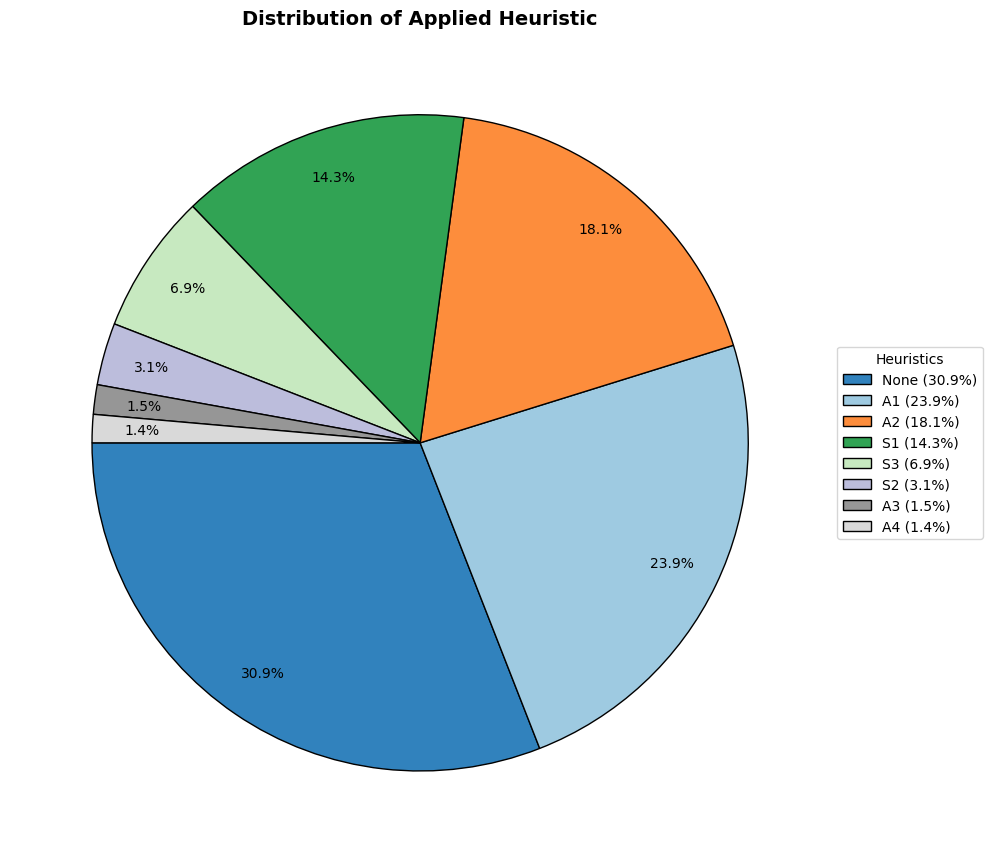

In [68]:
# Count the occurrences of each heuristic
heuristic_counts = df['AppliedHeuristic'].value_counts()

# Sort the heuristic counts by value
heuristic_counts = heuristic_counts.sort_values(ascending=False)

# Plot a pie chart with adjusted percentage layout
plt.figure(figsize=(10, 10))
heuristic_counts.plot.pie(
    labels=None,  # Remove labels from the pie chart
    autopct='%1.1f%%', 
    startangle=180, 
    cmap='tab20c',  # Professional color palette
    wedgeprops={'edgecolor': 'black'},  # Add black edges for better contrast
    textprops={'fontsize': 10},  # Adjust font size for percentages
    pctdistance=0.85  # Adjust the distance of percentages from the center
)
# plt.title('Distribution of Applied Heuristic', fontsize=14, fontweight='bold', loc='center')  # Center the title
plt.ylabel('')  # Remove the y-axis label for better visualization
plt.title('Distribution of Applied Heuristic', fontsize=14, fontweight='bold', loc='center')  # Center the title

# Add percentages to the legend
legend_labels = [f"{label} ({value}%)" for label, value in zip(heuristic_counts.index, (heuristic_counts / heuristic_counts.sum() * 100).round(1))]
plt.legend(
    legend_labels,
    title="Heuristics",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # Position the legend to the right of the chart
    fontsize=10,
    ncol=1  # Ensure the legend is vertical
)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## RQ2: Performance Analysis

### General Statistics on the Entire Dataset

### Time Ratios (Evolution Running Time / Evolution-Aware Running Time)

#### General funtions

In [69]:
def analyzeRatio(df, threshold: int):
    # Filter cases with valid times and heuristics
    valid_cases = df[
        (df['Evolution ExecutionTime(ms)'] < sys.maxsize) &
        (df['Evolution ExecutionTime(ms)'] > threshold) &
        (df['Evolution-Aware ExecutionTime (ms)'] < sys.maxsize) &
        (df['AppliedHeuristic'] != 'None')
    ].copy() 

    # Compute the ratio
    valid_cases['Time Ratio'] = (
        valid_cases['Evolution-Aware ExecutionTime (ms)'] / valid_cases['Evolution ExecutionTime(ms)']
    )

    plt.figure(figsize=(10, 6))

    # Reorder the heuristics: Sx first, then Ax
    heuristic_order = ['S1', 'S2', 'S3', 'A1', 'A2', 'A3', 'A4']
    valid_cases['AppliedHeuristic'] = pd.Categorical(valid_cases['AppliedHeuristic'], categories=heuristic_order, ordered=True)

    # Count how many samples per heuristic
    heuristic_counts = valid_cases['AppliedHeuristic'].value_counts().reindex(heuristic_order).dropna()

    # Update the tick labels with (n=...)
    xtick_labels = [f"{heuristic}\n(n={int(heuristic_counts[heuristic])})" for heuristic in heuristic_counts.index]

    # Create the boxplot with hue
    sns.boxplot(
        data=valid_cases,
        x='AppliedHeuristic',
        y='Time Ratio',
        hue='AppliedHeuristic',
        palette='muted',
        dodge=False,  # No offset between categories
        showfliers=False,  # Hide outliers
    )

    # Remove the legend
    plt.legend([], [], frameon=False)

    # Replace the x-tick labels
    plt.xticks(ticks=range(len(heuristic_counts)), labels=xtick_labels)

    # Final plot touches
    # plt.title('Box Plot of Time Ratios by Applied Heuristic')
    plt.xlabel('Applied Heuristics')
    plt.ylabel('Time Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Add a boxplot for all valid_cases Time Ratio
    plt.figure(figsize=(3, 6))
    sns.boxplot(data=valid_cases, y='Time Ratio', palette='muted', showfliers=False)

    # Count the number of samples
    n_values = len(valid_cases)

    # Add the count to the x-axis label
    plt.xlabel(f'All Heuristics\n(n={n_values})')
    plt.ylabel('Time Ratio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    plt.close()

    geo_mean_ratio = gmean(valid_cases['Time Ratio'])
    print(f"Geometric mean of the ratio between evolution-aware and evolution running times: {geo_mean_ratio:.4f}")


    # Calculate and print geometric mean and median for each heuristic
    for heuristic in heuristic_order:
        heuristic_cases = valid_cases[valid_cases['AppliedHeuristic'] == heuristic]
        if not heuristic_cases.empty:
            heuristic_gmean = gmean(heuristic_cases['Time Ratio'])
            heuristic_median = heuristic_cases['Time Ratio'].median()
            print(f"Heuristic: {heuristic}")
            print(f"  Geometric Mean of Time Ratio: {heuristic_gmean:.4f}")
            print(f"  Median of Time Ratio: {heuristic_median:.4f}\n")



#### Analysis for threshold of 30 Sec

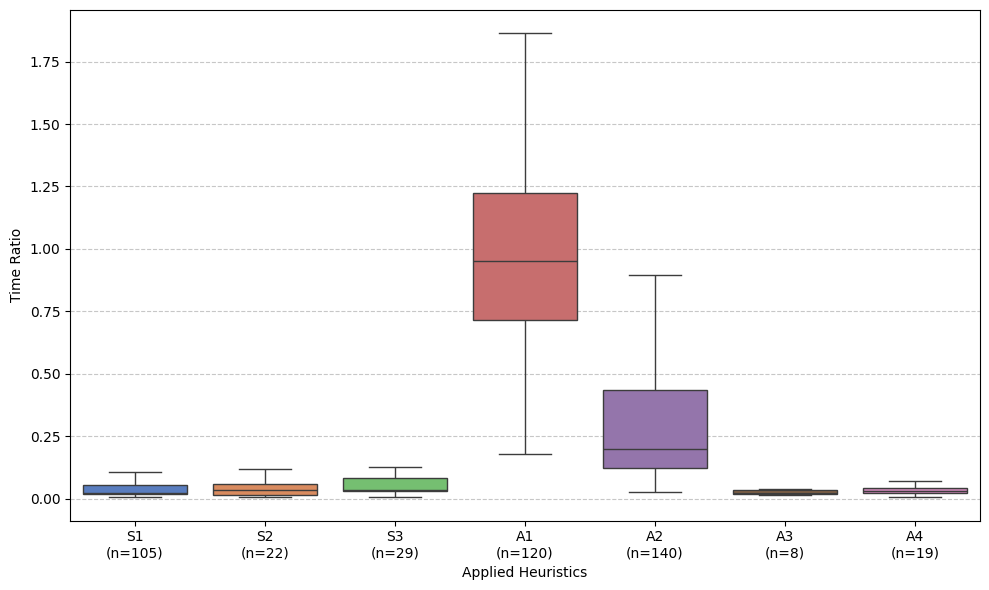

C:\Users\user\AppData\Local\Temp\ipykernel_33696\3703602323.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_cases, y='Time Ratio', palette='muted', showfliers=False)


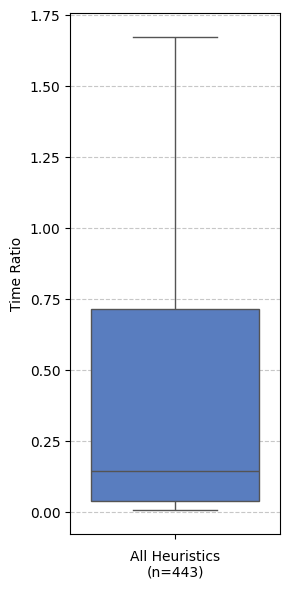

Geometric mean of the ratio between evolution-aware and evolution running times: 0.1521
Heuristic: S1
  Geometric Mean of Time Ratio: 0.0330
  Median of Time Ratio: 0.0250

Heuristic: S2
  Geometric Mean of Time Ratio: 0.0321
  Median of Time Ratio: 0.0336

Heuristic: S3
  Geometric Mean of Time Ratio: 0.0445
  Median of Time Ratio: 0.0370

Heuristic: A1
  Geometric Mean of Time Ratio: 0.9216
  Median of Time Ratio: 0.9525

Heuristic: A2
  Geometric Mean of Time Ratio: 0.2326
  Median of Time Ratio: 0.2003

Heuristic: A3
  Geometric Mean of Time Ratio: 0.0238
  Median of Time Ratio: 0.0230

Heuristic: A4
  Geometric Mean of Time Ratio: 0.0309
  Median of Time Ratio: 0.0303



In [70]:
analyzeRatio(df, 30000)

#### Analysis for threshold of 60 Sec

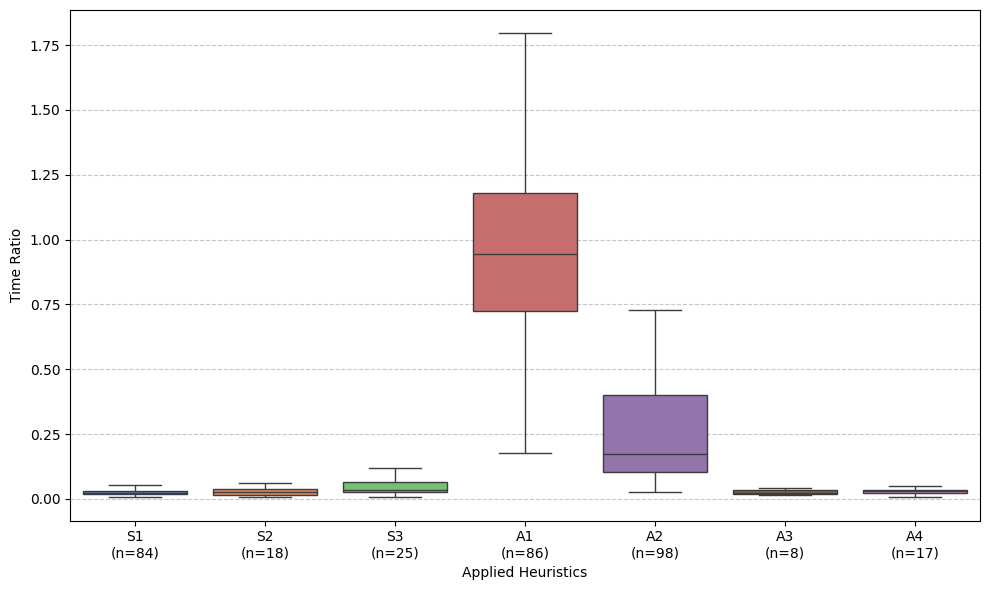

C:\Users\user\AppData\Local\Temp\ipykernel_33696\3703602323.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_cases, y='Time Ratio', palette='muted', showfliers=False)


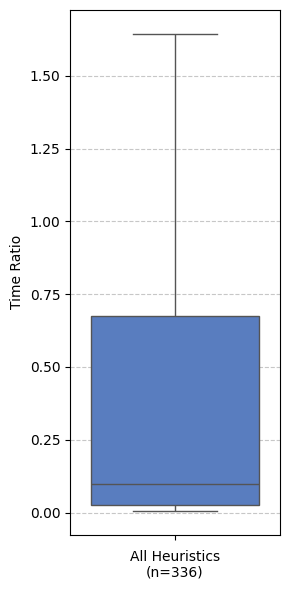

Geometric mean of the ratio between evolution-aware and evolution running times: 0.1203
Heuristic: S1
  Geometric Mean of Time Ratio: 0.0251
  Median of Time Ratio: 0.0217

Heuristic: S2
  Geometric Mean of Time Ratio: 0.0241
  Median of Time Ratio: 0.0269

Heuristic: S3
  Geometric Mean of Time Ratio: 0.0384
  Median of Time Ratio: 0.0352

Heuristic: A1
  Geometric Mean of Time Ratio: 0.8880
  Median of Time Ratio: 0.9462

Heuristic: A2
  Geometric Mean of Time Ratio: 0.2111
  Median of Time Ratio: 0.1723

Heuristic: A3
  Geometric Mean of Time Ratio: 0.0238
  Median of Time Ratio: 0.0230

Heuristic: A4
  Geometric Mean of Time Ratio: 0.0282
  Median of Time Ratio: 0.0298



In [71]:
analyzeRatio(df, 60000)

### Fixed-Point Iterations

In [72]:
valid_iterations = df[
    df[['xIterationsEvolution', 'yIterationsEvolution', 'zIterationsEvolution',
        'xIterationsEvolutionAware', 'yIterationsEvolutionAware', 'zIterationsEvolutionAware']].notnull().all(axis=1) & df['AppliedHeuristic'].notna() & df['AppliedHeuristic'].ne('None')
]

# Count rows where any of x, y, or z iterations decreased
decreased_count = ((valid_iterations['xIterationsEvolutionAware'] < valid_iterations['xIterationsEvolution']) | #).sum()
                   (valid_iterations['yIterationsEvolutionAware'] < valid_iterations['yIterationsEvolution']) |
                   (valid_iterations['zIterationsEvolutionAware'] < valid_iterations['zIterationsEvolution'])).sum()

print(f"Number of rows where x, y, or z iterations decreased: {decreased_count}")
print(f"Number of rows where x, y, or z iterations decreased: {decreased_count / len(valid_iterations) * 100:.2f}%\n")

# Count rows where any of x, y, or z iterations increased
increased_count = ((valid_iterations['xIterationsEvolutionAware'] > valid_iterations['xIterationsEvolution']) | #).sum()
                   (valid_iterations['yIterationsEvolutionAware'] > valid_iterations['yIterationsEvolution']) |
                   (valid_iterations['zIterationsEvolutionAware'] > valid_iterations['zIterationsEvolution'])).sum()

print(f"Number of rows where x, y, or z iterations increased: {increased_count}")
print(f"Number of rows where x, y, or z iterations increased: {increased_count / len(valid_iterations) * 100:.2f}%")


# Group by heuristic and calculate the counts for increased and decreased iterations
heuristic_counts = valid_iterations.groupby('AppliedHeuristic').apply(
    lambda group: pd.Series({
        'Decreased Count': ((group['xIterationsEvolutionAware'] < group['xIterationsEvolution']) |
                            (group['yIterationsEvolutionAware'] < group['yIterationsEvolution']) |
                            (group['zIterationsEvolutionAware'] < group['zIterationsEvolution'])).sum(),
        'Increased Count': ((group['xIterationsEvolutionAware'] > group['xIterationsEvolution']) |
                            (group['yIterationsEvolutionAware'] > group['yIterationsEvolution']) |
                            (group['zIterationsEvolutionAware'] > group['zIterationsEvolution'])).sum()
    })
)

# Display the counts per heuristic
print(heuristic_counts)

Number of rows where x, y, or z iterations decreased: 856
Number of rows where x, y, or z iterations decreased: 66.46%

Number of rows where x, y, or z iterations increased: 38
Number of rows where x, y, or z iterations increased: 2.95%
                  Decreased Count  Increased Count
AppliedHeuristic                                  
A1                            342               38
A2                            514                0


C:\Users\user\AppData\Local\Temp\ipykernel_33696\3505396171.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heuristic_counts = valid_iterations.groupby('AppliedHeuristic').apply(


### Timeout Analysis

In [73]:
timeout_count = df[df['Evolution ExecutionTime(ms)'] == sys.maxsize].shape[0]
print(f"Number of rows where evolution got timeout: {timeout_count}")

timeout_with_heuristic_count = df[(df['Evolution ExecutionTime(ms)'] == sys.maxsize) & (df['AppliedHeuristic'] != 'None')].shape[0]
print(f"Number of rows where evolution got timeout and a heuristic was applied: {timeout_with_heuristic_count}")

timeout_evolution_aware_not = df[(df['Evolution ExecutionTime(ms)'] == sys.maxsize) & 
                                 (df['Evolution-Aware ExecutionTime (ms)'] != sys.maxsize) & 
                                 (df['AppliedHeuristic'] != 'None')].shape[0]

percentage_evolution_aware_not = (timeout_evolution_aware_not / timeout_with_heuristic_count) * 100

print(f"Number of cases where evolution got timeout, but evolution aware didn't: {timeout_evolution_aware_not}")
print(f"Percentage of such cases out of all timeout cases with relevant heuristic: {percentage_evolution_aware_not:.2f}%")

# Filter the rows where evolution got timeout, but evolution aware didn't, and a heuristic was applied
filtered_df = df[(df['Evolution ExecutionTime(ms)'] == sys.maxsize) & 
                 (df['Evolution-Aware ExecutionTime (ms)'] != sys.maxsize) & 
                 (df['AppliedHeuristic'] != 'None')]

# Group by the applied heuristic and calculate the average time for 'Evolution-Aware ExecutionTime (ms)'
heuristic_avg_time = filtered_df.groupby('AppliedHeuristic')['Evolution-Aware ExecutionTime (ms)'].mean()

# Count the occurrences of each heuristic in the filtered DataFrame
heuristic_occurrences = filtered_df['AppliedHeuristic'].value_counts()

# Combine the average time and occurrences into a single DataFrame
heuristic_stats = pd.DataFrame({
    'Average Evolution-Aware ExecutionTime (ms)': heuristic_avg_time,
    'Occurrences': heuristic_occurrences
})

# Display the results
print("Heuristics applied and their statistics:")
print(heuristic_stats)


# Count cases where evolution didn't get timeout but evolution-aware did
evolution_not_timeout_aware_timeout = df[
    (df['Evolution ExecutionTime(ms)'] != sys.maxsize) & 
    (df['Evolution-Aware ExecutionTime (ms)'] == sys.maxsize) & 
    (df['AppliedHeuristic'] != 'None')
].shape[0]

print(f"Number of cases where evolution didn't get timeout but evolution-aware did: {evolution_not_timeout_aware_timeout}")

Number of rows where evolution got timeout: 46
Number of rows where evolution got timeout and a heuristic was applied: 26
Number of cases where evolution got timeout, but evolution aware didn't: 19
Percentage of such cases out of all timeout cases with relevant heuristic: 73.08%
Heuristics applied and their statistics:
                  Average Evolution-Aware ExecutionTime (ms)  Occurrences
AppliedHeuristic                                                         
A1                                             343015.444444            6
A2                                             148166.976190            7
S1                                               3540.166667            3
S2                                               4591.833333            2
S3                                               4557.000000            1
Number of cases where evolution didn't get timeout but evolution-aware did: 2


In [74]:
cases = df[(df['Evolution ExecutionTime(ms)'] != sys.maxsize) & 
           (df['Evolution-Aware ExecutionTime (ms)'] == sys.maxsize) &
           (df['AppliedHeuristic'] != 'None') &
           (df['AppliedHeuristic'] != 'nan')
           ]

print(f"Number of cases where evolution didn't get sys.maxsize but evolution-aware did: {len(cases)}")

# Print the heuristics applied in such cases
applied_heuristics = cases['AppliedHeuristic'].dropna().unique()
print(f"Heuristics applied in such cases: {', '.join(applied_heuristics)}")

Number of cases where evolution didn't get sys.maxsize but evolution-aware did: 2
Heuristics applied in such cases: A1


### Analysis of A1

In [75]:
# Filter and copy the subset explicitly to avoid SettingWithCopyWarning
a1_cases = df[
    (df['Evolution ExecutionTime(ms)'] < sys.maxsize) & 
    (df['Evolution ExecutionTime(ms)'] > 60000) &
    (df['Evolution-Aware ExecutionTime (ms)'] < sys.maxsize) &
    (df['AppliedHeuristic'] == 'A1')
].copy() 

# Sort by 'Time Ratio' in descending order
a1_cases_sorted = a1_cases.sort_values(by='Time Ratio', ascending=False)

# Select system/environment columns
system_environment_columns = [
    col for col in a1_cases.columns if col.startswith('system.') or col.startswith('environment.')
]

# Convert 'True'/'False' strings to 1/0 and compute correlation
correlation_results = {}
for col in system_environment_columns:
    a1_cases.loc[:, col] = a1_cases[col].map({'True': 1, 'False': 0})  # <--- Use .loc to avoid warning
    correlation_results[col] = a1_cases[[col, 'Time Ratio']].corr().iloc[0, 1]

# Sort and display the correlations
sorted_correlation_results = sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True)

print("Correlation between 'Time Ratio' and system/environment columns:\n")
for col, corr in sorted_correlation_results:
    print(f"{col}: {corr:.4f}")


# Filter a1_cases where environment.INI_WEAKENED or environment.SAFETY_WEAKENED is True
filtered_a1_cases = a1_cases[
    (a1_cases['environment.INI_WEAKENED'] == True) | 
    (a1_cases['environment.SAFETY_WEAKENED'] == True)
]

# Calculate geometric mean and median for a1_cases
a1_gmean = gmean(a1_cases['Time Ratio'])
a1_median = a1_cases['Time Ratio'].median()

# Calculate geometric mean and median for filtered_a1_cases
filtered_gmean = gmean(filtered_a1_cases['Time Ratio'])
filtered_median = filtered_a1_cases['Time Ratio'].median()

# Calculate geometric mean and median for cases in a1 but not in filtered
excluded_a1_cases = a1_cases[~a1_cases.index.isin(filtered_a1_cases.index)]
excluded_gmean = gmean(excluded_a1_cases['Time Ratio'])
excluded_median = excluded_a1_cases['Time Ratio'].median()

# Print the results
print(f"\nGeometric mean of TimeRatio for a1_cases: {a1_gmean:.4f}, Median: {a1_median:.4f}")
print(f"Geometric mean of TimeRatio for correlated A1 cases: {filtered_gmean:.4f}, Median: {filtered_median:.4f}")
print(f"Geometric mean of TimeRatio without correlated A1 cases: {excluded_gmean:.4f}, Median: {excluded_median:.4f}")
print(len(filtered_a1_cases['Time Ratio'])/len(a1_cases['Time Ratio']) * 100)

Correlation between 'Time Ratio' and system/environment columns:

system.INI_STRENGTHENED: nan
system.JUSTICE_STRENGTHENED: -0.1872
system.SAFETY_STRENGTHENED: -0.1490
system.INI_WEAKENED: nan
system.SAFETY_WEAKENED: nan
system.JUSTICE_WEAKENED: nan
environment.INI_STRENGTHENED: 0.0267
environment.SAFETY_STRENGTHENED: nan
environment.JUSTICE_STRENGTHENED: nan
environment.INI_WEAKENED: 0.3696
environment.SAFETY_WEAKENED: 0.3435
environment.JUSTICE_WEAKENED: -0.0835

Geometric mean of TimeRatio for a1_cases: 0.8880, Median: 0.9462
Geometric mean of TimeRatio for correlated A1 cases: 1.1219, Median: 1.0177
Geometric mean of TimeRatio without correlated A1 cases: 0.8154, Median: 0.8811
26.744186046511626


## RQ3: Overheads

Statistics for StoringBDDTime:
  Average: 2863.46
  Median: 85.33
  Max: 194791.33
  95% of the cases are lower than: 15172.40

Statistics for LoadingBDDTime:
  Average: 9.76
  Median: 3.00
  Max: 2013.33
  95% of the cases are lower than: 31.67

Statistics for GameComparisonTime:
  Average: 272.79
  Median: 19.33
  Max: 215278.67
  95% of the cases are lower than: 496.10

Statistics for LoadingPrevGameModelTime:
  Average: 2620.56
  Median: 2135.50
  Max: 276105.00
  95% of the cases are lower than: 3120.47

Statistics for LoadingCurrentGameModelTime:
  Average: 456.88
  Median: 220.00
  Max: 267203.67
  95% of the cases are lower than: 736.79



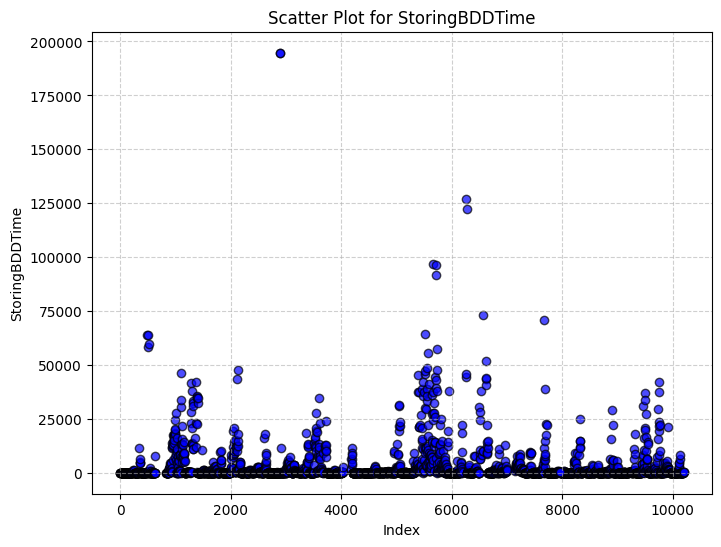

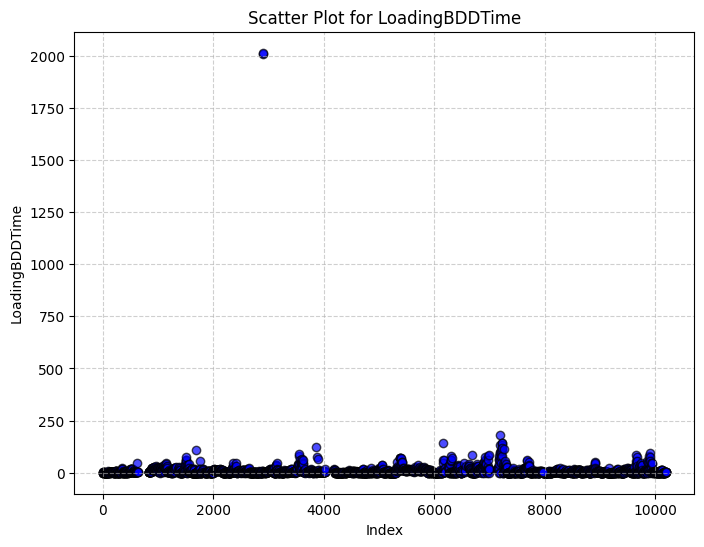

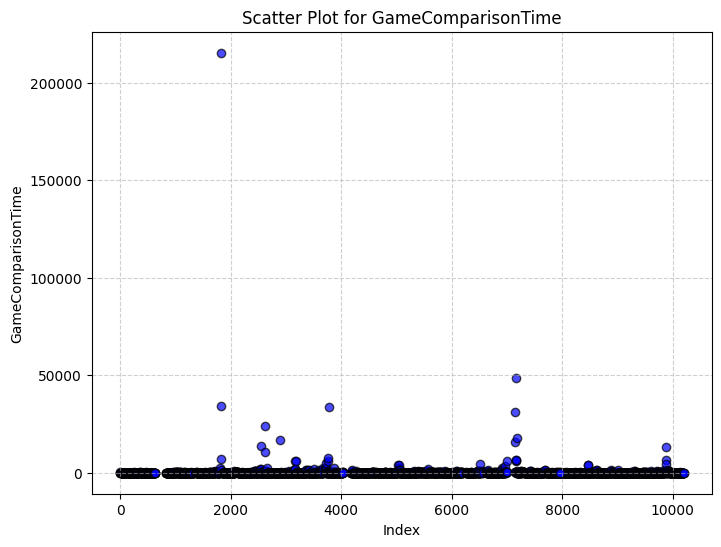

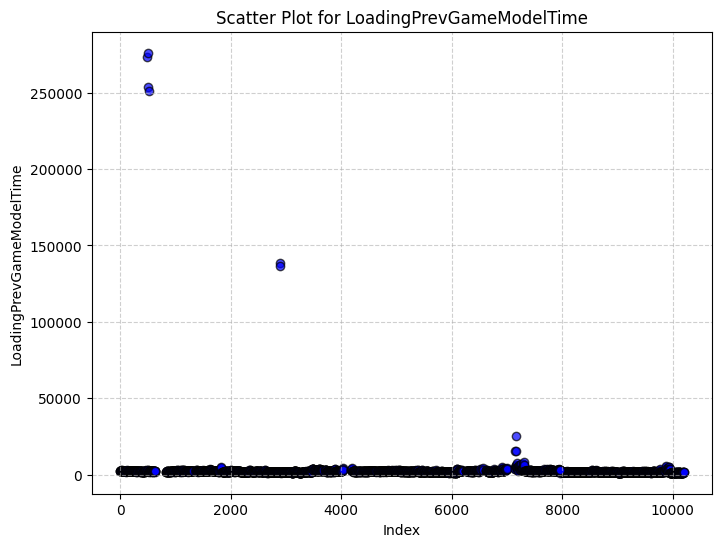

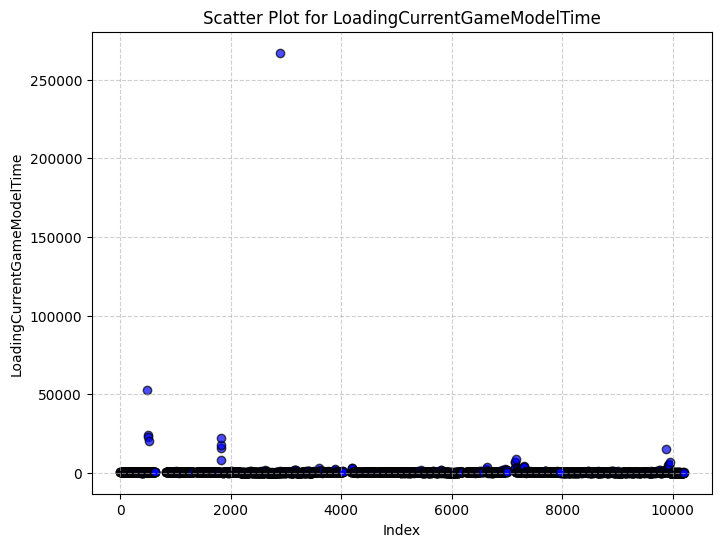

In [ ]:
# Scatter plots for each column
columns_to_plot = ['StoringBDDTime', 'LoadingBDDTime', 'GameComparisonTime', 
                   'LoadingPrevGameModelTime', 'LoadingCurrentGameModelTime']


for column in columns_to_plot:
    avg = df[column].mean()
    median = df[column].median()
    max_value = df[column].max()
    percentile_95 = df[column].quantile(0.95)
    
    print(f"Statistics for {column}:")
    print(f"  Average: {avg:.2f}")
    print(f"  Median: {median:.2f}")
    print(f"  Max: {max_value:.2f}")
    print(f"  95% of the cases are lower than: {percentile_95:.2f}")
    print()

for column in columns_to_plot:
    # Set percentile bounds (e.g., keep 1st to 99th percentile)
    lower_bound, upper_bound = np.percentile(df[column], [1, 99])

    # Filter out extreme values
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Plot the filtered data
    plt.figure(figsize=(8, 6))
    plt.scatter(filtered_df.index, filtered_df[column], alpha=0.7, color='blue', edgecolor='k')
    plt.title(f"Scatter Plot for {column} (Filtered)")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


3100
0.9193548387096774


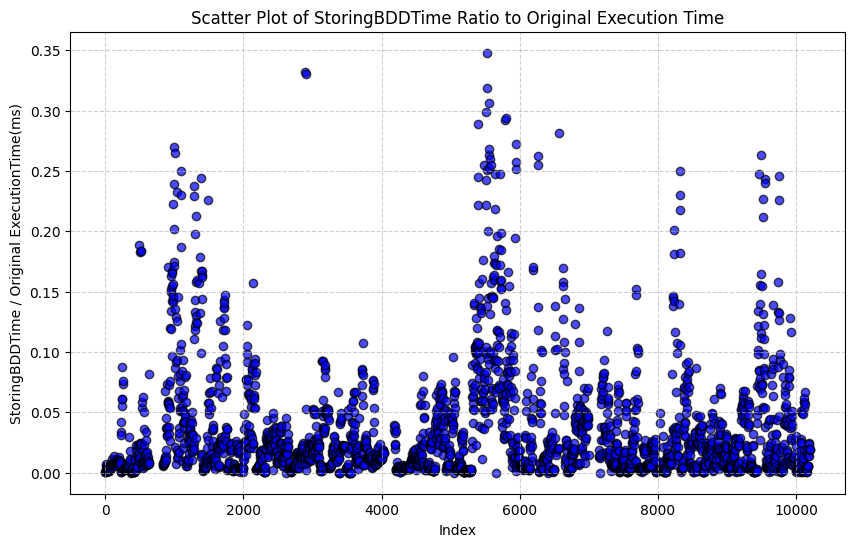

In [77]:
# Calculate the ratio
df['StoringBDDTime_Ratio'] = df['StoringBDDTime'] / df['Original ExecutionTime(ms)']

print(len(df))
print(len(df[df['StoringBDDTime_Ratio'] < 0.1])/len(df))

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['StoringBDDTime_Ratio'], alpha=0.7, color='blue', edgecolor='k')
plt.title("Scatter Plot of StoringBDDTime Ratio to Original Execution Time")
plt.xlabel("Index")
plt.ylabel("StoringBDDTime / Original ExecutionTime(ms)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()